# Example: Simultaneous Price and Volatility Simulation using the Heston Model
This example will familiarize students with computing the price and volatility of equity shares, i.e., shares of stock in a firm `XYZ` using the [Heston model](https://en.wikipedia.org/wiki/Heston_model). In the [Heston model](https://en.wikipedia.org/wiki/Heston_model), the price $X(t)$ and volatility $\nu$ are governed by:
\begin{eqnarray*}
dX & = & \mu\,{X}\,{dt} + \left(\sqrt{\nu}\right)\cdot{X}\cdot{dW}^{X} \\
d\nu & = & \kappa\left(\theta - \nu\right)dt +\left(\xi\sqrt{\nu}\right)\cdot{dW^{\nu}}
\end{eqnarray*}
where $\mu$ is the long-term drift (return growth rate), 
$\kappa$ is the rate of mean reversion for the volatility,
$\theta$ is the long-term volatility, and $\xi$ is the volatility of the volatility.
Finally, each equation of the [Heston model](https://en.wikipedia.org/wiki/Heston_model) 
is driven by a separate (potentially) correlated Weiner noise process, $dW^{X}$ (price) and $dW^{\nu}$ (volatility), respectively.

### Discrete model
The [Euler-Maruyama](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) discretization of the [Heston model](https://en.wikipedia.org/wiki/Heston_model) gives 
price and volatility equations of the form:
\begin{eqnarray*}
X_{k+1} & = & X_{k} + \mu\,{X_{k}}\,h + \left(\sqrt{\nu_{k}}\right)\cdot{X}_{k}\cdot\sqrt{h}\cdot{Z}^{X}(0,\Sigma)\\
\nu_{k+1} & = & \nu_{k} + \kappa\left(\theta - \nu_{k}\right) + \xi\left(\sqrt{\nu_{k}}\right)\cdot\sqrt{h}\cdot{Z}^{\nu}(0,\Sigma)
\end{eqnarray*}
where the price and volatility noise processes $Z^{X}$ and $Z^{\nu}$ are samples 
from a multivariate normal distribution with mean zero and a covariance matrix $\Sigma$, 
and $h$ denotes the time-step size.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example.

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Build, Simulate, and Visualize a Constant Parameter Heston Model
To simulate a [Heston model](https://en.wikipedia.org/wiki/Heston_model) with constant parameters, we first construct a `MyHestonModel` instance using a `build(...)` function. This type holds information about the model parameters, particularly the values of the $(\mu,\kappa,\theta,\xi)$ and covariance matrix $\Sigma$:
* In our implementation, we allow the $(\mu,\kappa,\theta,\xi)$ parameters to be updated during the simulation, e.g., to simulate the introduction of a new product by the firm that results in a price shift, or poor macroeconomic conditions which influences volatility, etc.
* We have implemented the $(\mu,\kappa,\theta,\sigma)$ parameters as simple functions that take in the state `x` and time `t` as arguments and return the value of the respective parameter at a time `t.` However, in this example implementation, we assumed the covariance matrix $\Sigma$ is constant.

We save the model instance in the variable `constantmodel`:

In [5]:
constantmodel = build(MyHestonModel, (
    μ = (x,t) -> 0.28,
    κ = (x,t) -> 40.0,
    θ = (x,t) -> 0.20,
    ξ = (x,t) -> 0.05,
    Σ = diagm(0.2*ones(2)) # diagonal, no correlation between price and volatility
));

### Check: Will the volatility always be positive?
The volatility equation can have negative solutions for particular combinations of model parameters. However, if the condition $2\kappa\theta>\xi^{2}$ is true, then the volatility will always be positive. 
* Let's check this condition for our choice of model parameters using the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). If this condition is `false`, then an [Assertion error](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown:

In [7]:
κ = constantmodel.κ(0,0);
θ = constantmodel.θ(0,0);
ξ = constantmodel.ξ(0,0);
@assert (2*κ*θ) > ξ^2

Next, now that we have verified our model parameters, let's specify the initial price and volatility, the number of sample paths, and the time span we want to simulate. 
* We save the initial condition in the `initialcondition` variable, the number of sample paths in the `N` variable, and the time span in the `tspan` variable:

In [9]:
initialcondition = [100.0, 0.30];
N = 2000;
tspan = (start = 0.0, stop = 125/252, step = 1/252); # start, stop, step, measured in trading days

Now, we solve the model equations using the `solve(...)` method. We pass in the `model` instance, the `tspan` variable, the `initialcondition` variable and the number of sample paths `N` as arguments. The `solve(...)` function returns the time vector `T1`, the state matrix `X1`, and the volatility matrix `V1`.
* The `solve(...)` method iterates the [Euler-Maruyama discretized](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) model equations for the time span and `N` sample paths and returns the simulation time vector `T1`, the price matrix `X1` and the volatility matrix `V1` as a [Tuple](https://docs.julialang.org/en/v1/manual/functions/#Tuples).
* Each row of `X1` and `V1` corresponds to a time point, while each column corresponds to a different sample path. During each time step, we also evaluate the $(\mu,\kappa,\theta,\sigma)$ parameter functions. In this case, these parameter functions always evaluate to constants.

In [11]:
(T1,X1,V1) = solve(constantmodel, tspan, initialcondition, N = N);

### Visualize
`Unhide` the code block below to see how we plot the solution of the [Heston model](https://en.wikipedia.org/wiki/Heston_model) for constant model parameters. 
* A thick red line shows the estimated expected price (left panel) and volatility (right panel). In contrast, the $\left\{1.0,1.96,2.576\right\}\cdot\hat{\sigma}$ range (where $\hat\sigma$ denotes the sample standard deviation) is shown in the shaded regions. The individual price and volatility trajectories, i.e., the sample paths, are shown as gray thin lines.

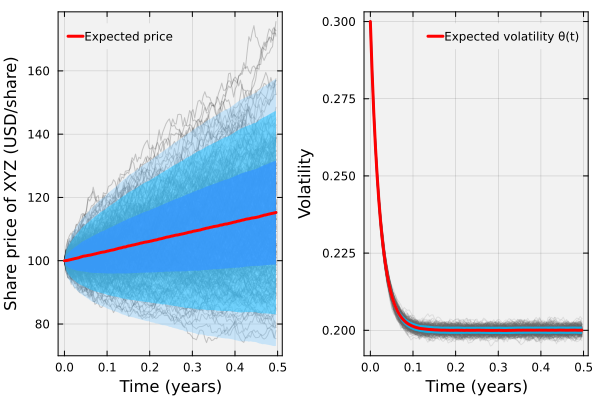

In [13]:
let
    p = plot(layout=(1,2));
    
    # Price
    mean_sim = mean(X1,dims=2)
    mean_std = std(X1,dims=2)
    N_σ = 1.0;
    L1 = mean_sim .- N_σ*(mean_std)
    U1 = mean_sim .+ N_σ*(mean_std)

    N_σ = 1.96;
    L2 = mean_sim .- N_σ*(mean_std)
    U2 = mean_sim .+ N_σ*(mean_std)

    N_σ = 2.576;
    L3 = mean_sim .- N_σ*(mean_std)
    U3 = mean_sim .+ N_σ*(mean_std)

    skip_range = range(1,step=6,stop=N);
    
    plot!(p,T1,X1[:,skip_range], label="", c="gray20", legend=:topleft, lw=1, bg="gray95", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent, alpha=0.25, subplot=1)
    plot!(p,T1, mean_sim,c="blue", fillrange=U1, fillalpha = 0.80, lw=2, label="", subplot=1)
    plot!(p,T1, mean_sim,c="blue", fillrange=L1, fillalpha = 0.80, lw=2, label="", subplot=1)
    plot!(p,T1, mean_sim,c="deepskyblue", fillrange=U2, fillalpha = 0.6, lw=2, label="", subplot=1)
    plot!(p,T1, mean_sim,c="deepskyblue", fillrange=L2, fillalpha = 0.6, lw=2, label="", subplot=1)
    plot!(p,T1, mean_sim,c="skyblue1", fillrange=U3, fillalpha = 0.4, lw=2, label="", subplot=1)
    plot!(p,T1, mean_sim,c="skyblue1", fillrange=L3, fillalpha = 0.4, lw=2, label="", subplot=1)
    plot!(p,T1, mean_sim,c=:red,lw=3,label="Expected price", subplot=1)
    xlabel!("Time (years)", fontsize=18, subplot=1)
    ylabel!("Share price of XYZ (USD/share)", fontsize=18, subplot=1)

    # Volatility
    mean_sim = mean(V1,dims=2)
    mean_std = std(V1,dims=2)
    N_σ = 1.0;
    L = mean_sim .- N_σ*(mean_std)
    U = mean_sim .+ N_σ*(mean_std)
    plot!(p,T1,V1[:,skip_range], label="", c="gray40", legend=:topright, lw=1, bg="gray95", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent, alpha=0.15, subplot=2)
    plot!(p,T1, mean_sim,c="deepskyblue1", fillrange=U, fillalpha = 0.8, lw=2, label="", subplot=2)
    plot!(p,T1, mean_sim,c="deepskyblue1", fillrange=L, fillalpha = 0.8, lw=2, label="", subplot=2)
    plot!(p,T1, mean_sim,c=:red,lw=3,label="Expected volatility θ(t)", subplot=2)
    xlabel!("Time (years)", fontsize=18, subplot=2)
    ylabel!("Volatility", fontsize=18, subplot=2)
end

## Build, Simulate and Visualize a Dynamic Parameter Heston Model
Now, let's simulate a [Heston model](https://en.wikipedia.org/wiki/Heston_model) with dynamics parameters. Like befor we construct a `MyHestonModel` instance using a `build(...)` function. This type holds information about the model parameters, particularly the values of the $(\mu,\kappa,\theta,\xi)$ and covariance matrix $\Sigma$:
* In our implementation, we allow the $(\mu,\kappa,\theta,\xi)$ parameters to be updated during the simulation, e.g., to simulate the introduction of a new product by the firm that results in a price shift, or poor macroeconomic conditions which influences volatility, etc.
* We have implemented the $(\mu,\kappa,\theta,\sigma)$ parameters as simple functions that take in the state `x` and time `t` as arguments and return the value of the respective parameter at a time `t.` iIn this example implementation, we assumed the covariance matrix $\Sigma$ is constant.

We save the model instance in the variable `dynamicmodel`:

In [38]:
dynamicmodel = build(MyHestonModel, (
    μ = (x,t) -> 0.28,
    κ = (x,t) -> 50.0,
    θ = (x,t) -> t ≥ 0.25 ? 0.64*t+0.20 : 0.20,
    ξ = (x,t) -> 0.05,
    Σ = diagm(0.20*ones(2)) # diagonal
));

Now, we solve the model equations using the `solve(...)` method. We pass in the `model` instance, the `tspan` variable, the `initialcondition` variable and the number of sample paths `N` as arguments. The `solve(...)` function returns the time vector `T1`, the state matrix `X1`, and the volatility matrix `V1`.
* The `solve(...)` method iterates the [Euler-Maruyama discretized](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) model equations for the time span and `N` sample paths and returns the simulation time vector `T1`, the price matrix `X1` and the volatility matrix `V1` as a [Tuple](https://docs.julialang.org/en/v1/manual/functions/#Tuples).
* Each row of `X1` and `V1` corresponds to a time point, while each column corresponds to a different sample path. During each time step, we also evaluate the $(\mu,\kappa,\theta,\sigma)$ parameter functions. In this second case, we let the $\mu$ parameter vary with time, with everything else held constant.

In [40]:
(T2,X2,V2) = solve(dynamicmodel, tspan, initialcondition, N = N);

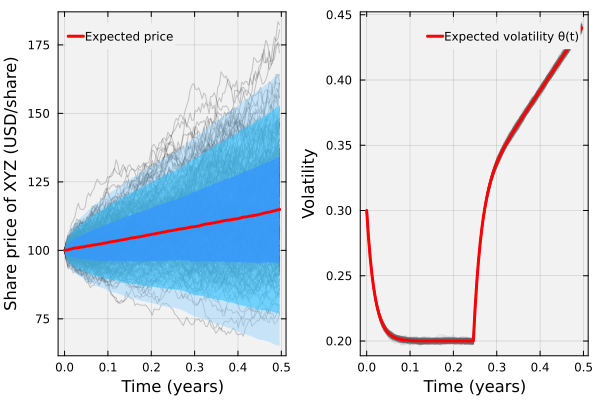

In [44]:
let
    p = plot(layout=(1,2));
    
    # Price
    mean_sim = mean(X2,dims=2)
    mean_std = std(X2,dims=2)
    N_σ = 1.0;
    L1 = mean_sim .- N_σ*(mean_std)
    U1 = mean_sim .+ N_σ*(mean_std)

    N_σ = 1.96;
    L2 = mean_sim .- N_σ*(mean_std)
    U2 = mean_sim .+ N_σ*(mean_std)

    N_σ = 2.576;
    L3 = mean_sim .- N_σ*(mean_std)
    U3 = mean_sim .+ N_σ*(mean_std)

    skip_range = range(1,step=6,stop=N);
    
    plot!(p,T2,X2[:,skip_range], label="", c="gray20", legend=:topleft, lw=1, bg="gray95", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent, alpha=0.25, subplot=1)
    plot!(p,T2, mean_sim,c="blue", fillrange=U1, fillalpha = 0.80, lw=2, label="", subplot=1)
    plot!(p,T2, mean_sim,c="blue", fillrange=L1, fillalpha = 0.80, lw=2, label="", subplot=1)
    plot!(p,T2, mean_sim,c="deepskyblue", fillrange=U2, fillalpha = 0.6, lw=2, label="", subplot=1)
    plot!(p,T2, mean_sim,c="deepskyblue", fillrange=L2, fillalpha = 0.6, lw=2, label="", subplot=1)
    plot!(p,T2, mean_sim,c="skyblue1", fillrange=U3, fillalpha = 0.4, lw=2, label="", subplot=1)
    plot!(p,T2, mean_sim,c="skyblue1", fillrange=L3, fillalpha = 0.4, lw=2, label="", subplot=1)
    plot!(p,T2, mean_sim,c=:red,lw=3,label="Expected price", subplot=1)
    xlabel!("Time (years)", fontsize=18, subplot=1)
    ylabel!("Share price of XYZ (USD/share)", fontsize=18, subplot=1)

    # Volatility
    mean_sim = mean(V2,dims=2)
    mean_std = std(V2,dims=2)
    N_σ = 1.0;
    L = mean_sim .- N_σ*(mean_std)
    U = mean_sim .+ N_σ*(mean_std)
    plot!(p,T2,V2[:,skip_range], label="", c="gray40", legend=:topright, lw=1, bg="gray95", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent, alpha=0.15, subplot=2)
    plot!(p,T2, mean_sim,c="deepskyblue1", fillrange=U, fillalpha = 0.8, lw=2, label="", subplot=2)
    plot!(p,T2, mean_sim,c="deepskyblue1", fillrange=L, fillalpha = 0.8, lw=2, label="", subplot=2)
    plot!(p,T2, mean_sim,c=:red,lw=3,label="Expected volatility θ(t)", subplot=2)
    xlabel!("Time (years)", fontsize=18, subplot=2)
    ylabel!("Volatility", fontsize=18, subplot=2)
end

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.